<a href="https://colab.research.google.com/github/ASHUTOSH-THAPA/Neural-Network-on-FashionMNIST-Multi-class-Classification-with-PyTorch-/blob/main/Building_ANN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install optuna

In [ ]:
import torch
import optuna
import torch.nn as nn
import pandas as pd
import warnings
from google.colab import drive
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available()else "cpu")

In [ ]:
torch.manual_seed(42)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

## Visualizing samples before training

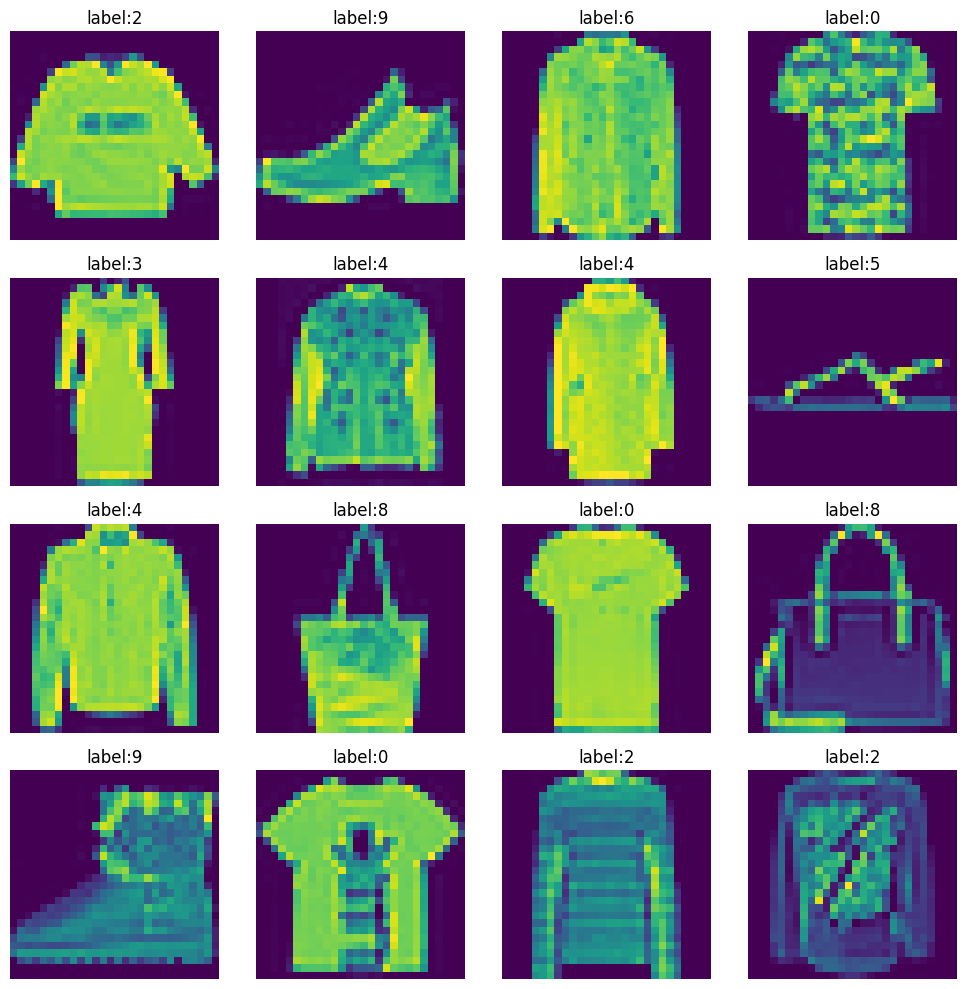

In [ ]:
#plot 16 images in 4x4 grid
fig,axes=plt.subplots(4,4,figsize=(10,10))

for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28) # reshape to 28x28
  ax.imshow(img) # display gray scale
  ax.axis('off') # remove axis for cleaner look
  ax.set_title(f"label:{df.iloc[i,0]}") # show label
plt.tight_layout() # adjust layout
plt.show()

In [ ]:
x=df.iloc[i,1:].values
y=df.iloc[:,0].values

In [ ]:
print(x.shape)  # should be [batch_size, 784] for 28x28 images


(784,)


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(df.iloc[:,1:],df.iloc[:,0],test_size=0.2,random_state=42)

In [ ]:
y_train.shape

(48000,)

In [ ]:
# scaling the features
X_train=X_train.astype("float32")/255.0
X_test=X_test.astype("float32")/255.0

In [ ]:
# create CustumDataset class
class CustomDataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features.values,dtype=torch.float32)
    self.labels=torch.tensor(labels.values,dtype=torch.long)
  def __len__(self):
    return len(self.features)
  def __getitem__(self,index):
    return   self.features[index],self.labels[index]



In [ ]:
# create train and test dataset object
train_dataset=CustomDataset(X_train,y_train)
test_dataset=CustomDataset(X_test,y_test)

In [ ]:
# create train and test loader object
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)

In [ ]:
class Mynn(nn.Module):
  def __init__(self,input_dim,output_dim,num_hidden_layers,neuron_per_layer):
    super().__init__()
    layers=[]
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim,neuron_per_layer))
      layers.append(nn.BatchNorm1d(neuron_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=0.3))
      input_dim=neuron_per_layer
    layers.append(nn.Linear(input_dim,output_dim))
    self.model=nn.Sequential(*layers)
  def forward(self,x):
    return self.model(x)


In [ ]:
# object function
def objective(trial):
  # next hyperparameter values from the search space
  num_hidden_layers=trial.suggest_int("num_hidden_layers",1,5)
  neuron_per_layer=trial.suggest_int("neuron_per_layer",8,128,step=8)
  # model initializing
  input_dim=X_train.shape[1]
  output_dim=10
  model=Mynn(input_dim,output_dim,num_hidden_layers,neuron_per_layer)
  model=model.to(device)
  # set learning rate and epochs
  learning_rate=0.001
  epochs=100
  # loss function
  loss_func=nn.CrossEntropyLoss()
  # optimizer
  optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)
  # traing loop
  for epoch in range(epochs):
    for batch_feature,batch_label in train_loader:
      # move data to gpu
      batch_feature,batch_label=batch_feature.to(device),batch_label.to(device)
      # forward pass
      output=model(batch_feature)
      # loss function
      loss=loss_func(output,batch_label)
      #clear grad
      optimizer.zero_grad()
      # backpass
      loss.backward()
      #update
      optimizer.step()
  # # set eval mode, tells model that we are using evalution
  model.eval()
  all_preds=[]
  all_labels=[]
  with torch.no_grad():
    for batch_feature,batch_label in test_loader:
      batch_feature,batch_label=batch_feature.to(device),batch_label.to(device)
      output=model(batch_feature)
      _, predicted=torch.max(output,1)
      all_preds.extend(predicted.tolist())
      all_labels.extend(batch_label.tolist())
  accuracy=accuracy_score(all_labels,all_preds)
  return accuracy

In [ ]:
# create study object
study=optuna.create_study(direction="maximize")

[I 2025-07-09 11:16:47,071] A new study created in memory with name: no-name-ffe430d6-4291-4e00-94e4-9034c89b5810


In [ ]:
study.optimize(objective,n_trials=10)

[I 2025-07-09 11:25:44,822] Trial 0 finished with value: 0.7094166666666667 and parameters: {'num_hidden_layers': 4, 'neuron_per_layer': 16}. Best is trial 0 with value: 0.7094166666666667.
[I 2025-07-09 11:33:37,580] Trial 1 finished with value: 0.884 and parameters: {'num_hidden_layers': 3, 'neuron_per_layer': 104}. Best is trial 1 with value: 0.884.
[I 2025-07-09 11:39:17,075] Trial 2 finished with value: 0.8805 and parameters: {'num_hidden_layers': 1, 'neuron_per_layer': 88}. Best is trial 1 with value: 0.884.
[I 2025-07-09 11:49:13,272] Trial 3 finished with value: 0.8785 and parameters: {'num_hidden_layers': 5, 'neuron_per_layer': 80}. Best is trial 1 with value: 0.884.
[I 2025-07-09 11:58:09,532] Trial 4 finished with value: 0.8708333333333333 and parameters: {'num_hidden_layers': 4, 'neuron_per_layer': 48}. Best is trial 1 with value: 0.884.
[I 2025-07-09 12:04:53,175] Trial 5 finished with value: 0.8306666666666667 and parameters: {'num_hidden_layers': 2, 'neuron_per_layer': 1